# Workflow

En esta práctica vamos a aplicar lo aprendido en esta asignatura para crear un flujo que automatice la descarga, análisis y publicación de los datos utilizando distintas herramientas como Zenodo, github y librerías de python para el análisis de datos

### Librerías necesarias para la práctica

```python
import xml.etree.ElementTree as ET
import requests
import json
import zipfile
```

### Elementos necesarios
* Al menos un fichero CSV
* Un script de análisis de datos en CSV (Publicado en Github)


In [7]:
import xml.etree.ElementTree as ET
import requests
import json
import zipfile

# Publicación de datos iniciales

Utilizando Zenodo, de forma manual, publicar los datos que se vayan a utilizar.

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>Utilizar Communities para localizar más facilmente los datos</p>
</div>


# Publicación de script de Análisis

En Github + Zenodo

# Descarga de datos

Desde Zenodo, utilizando los métodos conocidos (OAI-PMH, API)

Pista: url+'?verb=ListRecords&set=nombre_set

https://zenodo.org/record/2541848

List Records:

In [58]:
zen_url = 'https://zenodo.org/oai2d'
verb = '?verb=ListRecords'
comm = '&set=user-iipr_dlc_unican&metadataPrefix=oai_dc'

In [59]:
oai = requests.get(zen_url + verb + comm)
namespaces = {'oai': 'http://www.openarchives.org/OAI/2.0/'}

# Para crear el arbol XML
xmlTree = ET.fromstring(oai.text)

iterator = xmlTree.iter()
for e in iterator:
    print(e.tag, '->', e.text)

{http://www.openarchives.org/OAI/2.0/}OAI-PMH -> 
  
{http://www.openarchives.org/OAI/2.0/}responseDate -> 2019-01-16T18:42:09Z
{http://www.openarchives.org/OAI/2.0/}request -> https://zenodo.org/oai2d
{http://www.openarchives.org/OAI/2.0/}ListRecords -> 
    
{http://www.openarchives.org/OAI/2.0/}record -> 
      
{http://www.openarchives.org/OAI/2.0/}header -> 
        
{http://www.openarchives.org/OAI/2.0/}identifier -> oai:zenodo.org:2542012
{http://www.openarchives.org/OAI/2.0/}datestamp -> 2019-01-16T18:41:31Z
{http://www.openarchives.org/OAI/2.0/}setSpec -> user-iipr_dlc_unican
{http://www.openarchives.org/OAI/2.0/}metadata -> 
        
{http://www.openarchives.org/OAI/2.0/oai_dc/}dc -> 
          
{http://purl.org/dc/elements/1.1/}creator -> Ignacio Iker Prado Rujas
{http://purl.org/dc/elements/1.1/}date -> 2019-01-16
{http://purl.org/dc/elements/1.1/}description -> This is a first test release to check zenodo's integration with GitHub.
{http://purl.org/dc/elements/1.1/}identif

Get Record:

In [60]:
verb = '?verb=GetRecord'
comm = '&metadataPrefix=oai_dc&identifier=oai:zenodo.org:2541848'

In [61]:
oai = requests.get(zen_url + verb + comm)
xmlTree = ET.fromstring(oai.text)
iterator = xmlTree.iter()
for elem in iterator:
    print(elem.tag + ': ' + elem.text)

{http://www.openarchives.org/OAI/2.0/}OAI-PMH: 
  
{http://www.openarchives.org/OAI/2.0/}responseDate: 2019-01-16T18:42:13Z
{http://www.openarchives.org/OAI/2.0/}request: https://zenodo.org/oai2d
{http://www.openarchives.org/OAI/2.0/}GetRecord: 
    
{http://www.openarchives.org/OAI/2.0/}record: 
      
{http://www.openarchives.org/OAI/2.0/}header: 
        
{http://www.openarchives.org/OAI/2.0/}identifier: oai:zenodo.org:2541848
{http://www.openarchives.org/OAI/2.0/}datestamp: 2019-01-16T16:13:01Z
{http://www.openarchives.org/OAI/2.0/}setSpec: user-iipr_dlc_unican
{http://www.openarchives.org/OAI/2.0/}metadata: 
        
{http://www.openarchives.org/OAI/2.0/oai_dc/}dc: 
          
{http://purl.org/dc/elements/1.1/}creator: Prado Rujas, Ignacio Iker
{http://purl.org/dc/elements/1.1/}date: 2019-01-16
{http://purl.org/dc/elements/1.1/}description: Link to basic metadata.

Link to extended description.
{http://purl.org/dc/elements/1.1/}identifier: https://zenodo.org/record/2541848
{http:/

In [43]:
headers = {'accept': 'application/json'}
r = requests.get('https://zenodo.org/api/records/2541848',headers)
record = json.loads(r.text)
print(record['files'])

[{'bucket': '6eb594d2-693a-43d8-8670-7e33e00b2b85', 'checksum': 'md5:ef8240eb8d0b13caf07c8cf0d99a30cc', 'key': 'lfsq_ergaed.tsv.gz', 'links': {'self': 'https://zenodo.org/api/files/6eb594d2-693a-43d8-8670-7e33e00b2b85/lfsq_ergaed.tsv.gz'}, 'size': 1956221, 'type': 'gz'}]


In [47]:
data_url = record['files'][0]['links']['self']
with open('lfsq_ergaed.tsv.gz', 'wb') as f:
    f.write(requests.get(data_url).content)

También descomprimimos:

In [49]:
!gunzip lfsq_ergaed.tsv.gz

In [50]:
!ls -la

total 7752
drwxrwxr-x 4 iker iker    4096 ene 16 19:37 .
drwxrwxr-x 7 iker iker    4096 ene 16 17:19 ..
drwxrwxr-x 8 iker iker    4096 ene 16 17:03 .git
drwxrwxr-x 2 iker iker    4096 ene 16 17:07 .ipynb_checkpoints
-rw-rw-r-- 1 iker iker 7901493 ene 16 19:36 lfsq_ergaed.tsv
-rw-rw-r-- 1 iker iker   11774 ene 16 19:36 M3.02Workflow.ipynb
-rw-rw-r-- 1 iker iker      18 ene 16 17:03 README.md


# Descarga de código

Desde Zenodo, utilizando los métodos conocidos (OAI-PMH, API)

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>Zenodo guarda un zip con el código</p>
</div>

https://github.com/iipr-Master-Data-Science/zenodo_integration/

http://doi.org/10.5281/zenodo.2542012

List Records:

In [62]:
zen_url = 'https://zenodo.org/oai2d'
verb = '?verb=ListRecords'
comm = '&set=user-iipr_dlc_unican&metadataPrefix=oai_dc'

In [63]:
oai = requests.get(zen_url + verb + comm)
namespaces = {'oai': 'http://www.openarchives.org/OAI/2.0/'}

# Para crear el arbol XML
xmlTree = ET.fromstring(oai.text)

iterator = xmlTree.iter()
for e in iterator:
    print(e.tag, '->', e.text)

{http://www.openarchives.org/OAI/2.0/}OAI-PMH -> 
  
{http://www.openarchives.org/OAI/2.0/}responseDate -> 2019-01-16T18:43:01Z
{http://www.openarchives.org/OAI/2.0/}request -> https://zenodo.org/oai2d
{http://www.openarchives.org/OAI/2.0/}ListRecords -> 
    
{http://www.openarchives.org/OAI/2.0/}record -> 
      
{http://www.openarchives.org/OAI/2.0/}header -> 
        
{http://www.openarchives.org/OAI/2.0/}identifier -> oai:zenodo.org:2542012
{http://www.openarchives.org/OAI/2.0/}datestamp -> 2019-01-16T18:41:31Z
{http://www.openarchives.org/OAI/2.0/}setSpec -> user-iipr_dlc_unican
{http://www.openarchives.org/OAI/2.0/}metadata -> 
        
{http://www.openarchives.org/OAI/2.0/oai_dc/}dc -> 
          
{http://purl.org/dc/elements/1.1/}creator -> Ignacio Iker Prado Rujas
{http://purl.org/dc/elements/1.1/}date -> 2019-01-16
{http://purl.org/dc/elements/1.1/}description -> This is a first test release to check zenodo's integration with GitHub.
{http://purl.org/dc/elements/1.1/}identif

Get Record:

In [64]:
verb = '?verb=GetRecord'
comm = '&metadataPrefix=oai_dc&identifier=oai:zenodo.org:2542012'

In [65]:
oai = requests.get(zen_url + verb + comm)
xmlTree = ET.fromstring(oai.text)
iterator = xmlTree.iter()
for elem in iterator:
    print(elem.tag + ': ' + elem.text)

{http://www.openarchives.org/OAI/2.0/}OAI-PMH: 
  
{http://www.openarchives.org/OAI/2.0/}responseDate: 2019-01-16T18:43:47Z
{http://www.openarchives.org/OAI/2.0/}request: https://zenodo.org/oai2d
{http://www.openarchives.org/OAI/2.0/}GetRecord: 
    
{http://www.openarchives.org/OAI/2.0/}record: 
      
{http://www.openarchives.org/OAI/2.0/}header: 
        
{http://www.openarchives.org/OAI/2.0/}identifier: oai:zenodo.org:2542012
{http://www.openarchives.org/OAI/2.0/}datestamp: 2019-01-16T18:41:31Z
{http://www.openarchives.org/OAI/2.0/}setSpec: user-iipr_dlc_unican
{http://www.openarchives.org/OAI/2.0/}metadata: 
        
{http://www.openarchives.org/OAI/2.0/oai_dc/}dc: 
          
{http://purl.org/dc/elements/1.1/}creator: Ignacio Iker Prado Rujas
{http://purl.org/dc/elements/1.1/}date: 2019-01-16
{http://purl.org/dc/elements/1.1/}description: This is a first test release to check zenodo's integration with GitHub.
{http://purl.org/dc/elements/1.1/}identifier: https://zenodo.org/record

In [67]:
headers = {'accept': 'application/json'}
r = requests.get('https://zenodo.org/api/records/2542012',headers)
record = json.loads(r.text)
print(record['files'])

[{'bucket': '230b6e57-534d-40df-bc8b-05726866b6b3', 'checksum': 'md5:57206ae2a043c042e786b59ee8a36305', 'key': 'iipr-Master-Data-Science/zenodo_integration-v0.1.zip', 'links': {'self': 'https://zenodo.org/api/files/230b6e57-534d-40df-bc8b-05726866b6b3/iipr-Master-Data-Science/zenodo_integration-v0.1.zip'}, 'size': 15619, 'type': 'zip'}]


In [68]:
code_url = record['files'][0]['links']['self']
with open('zenodo_integration-v0.1.zip', 'wb') as f:
    f.write(requests.get(code_url).content)

Decomprimimos:

In [69]:
!unzip zenodo_integration-v0.1.zip

Archive:  zenodo_integration-v0.1.zip
d756f183b4fa8c545d77823ef31c148a8375d7cd
   creating: iipr-Master-Data-Science-zenodo_integration-d756f18/
  inflating: iipr-Master-Data-Science-zenodo_integration-d756f18/.gitignore  
  inflating: iipr-Master-Data-Science-zenodo_integration-d756f18/LICENSE  
  inflating: iipr-Master-Data-Science-zenodo_integration-d756f18/README.md  
  inflating: iipr-Master-Data-Science-zenodo_integration-d756f18/make_plots.py  


Movemos los datos a la carpeta del script para que pueda encontrarlos:

In [77]:
#!mv lfsq_ergaed.tsv iipr-Master-Data-Science-zenodo_integration-d756f18

# Análisis de los datos

Producir fichero: Otro CSV, imagen, etc

3.7.1 (default, Oct 20 2018, 21:59:34) 
[GCC 5.4.0 20160609]
Sexs: ['F' 'M' 'T']
Geos: ['AT' 'BE' 'BG' 'CH' 'CY' 'CZ' 'DE' 'DK' 'EA17' 'EA18' 'EA19' 'EE' 'EL'
 'ES' 'EU15' 'EU27' 'EU28' 'FI' 'FR' 'HR' 'HU' 'IE' 'IS' 'IT' 'LT' 'LU'
 'LV' 'ME' 'MK' 'MT' 'NL' 'NO' 'PL' 'PT' 'RO' 'RS' 'SE' 'SI' 'SK' 'TR'
 'UK']
Age ranges: ['Y15-19' 'Y15-24' 'Y15-39' 'Y15-59' 'Y15-64' 'Y15-74' 'Y20-24' 'Y20-64'
 'Y25-29' 'Y25-49' 'Y25-54' 'Y25-59' 'Y25-64' 'Y25-74' 'Y30-34' 'Y35-39'
 'Y40-44' 'Y40-59' 'Y40-64' 'Y45-49' 'Y50-54' 'Y50-59' 'Y50-64' 'Y50-74'
 'Y55-59' 'Y55-64' 'Y60-64' 'Y65-69' 'Y65-74' 'Y70-74']
Educational levels: ['ED0-2' 'ED3_4' 'ED5-8' 'NRP' 'TOTAL']


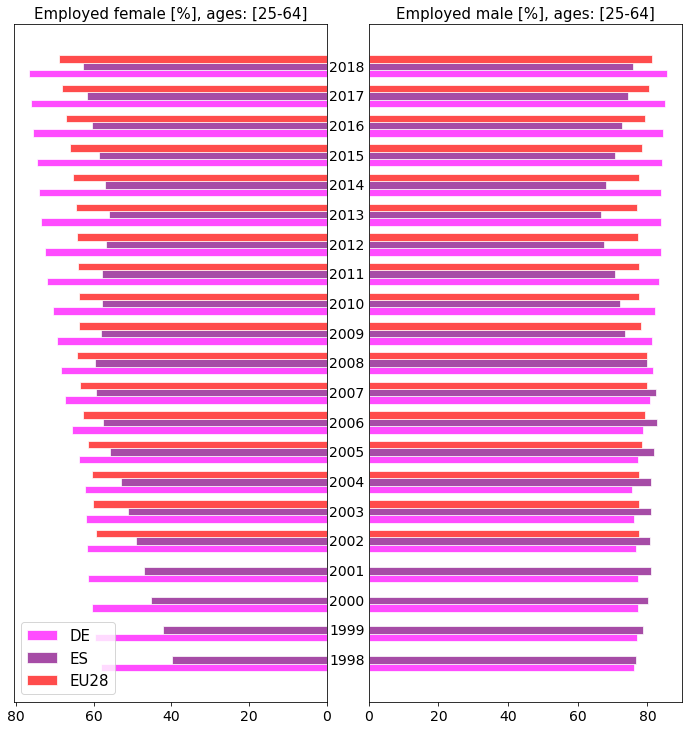

In [76]:
%run -i iipr-Master-Data-Science-zenodo_integration-d756f18/make_plots.py 

# Publicación de los Datos

Utilizando la API de Zenodo

¿Puedes replicar ese workflow en un sólo bloque con otros datos?